In [4]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [7]:
def u236_of_enrichment(enrichment):
    return 1e-5 * (9.4 + 0.6 * np.log(enrichment/100))

In [8]:
u236_of_enrichment(90)

9.336783690605306e-05

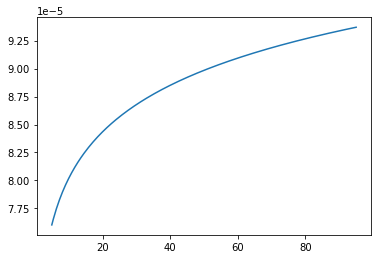

In [9]:
xs = np.linspace(5, 95, 200)
plt.plot(xs, u236_of_enrichment(xs))

## What?

We model the enrichment curve using `u236_of_enrichment()`, which slightly looks like the real enrichment curve. It doesn't really matter, but this way we can more easily compare.

We take `observations` that in reality would come from cyclus; they are randomly distributed around the "true" U-236 concentration shown above; our enrichment grade is 90%, and we aim to reconstruct this value.

We then sample different enrichments from \[5, 95\]% -- just like in the real model. For each enrichment we short-circuit the whole Cyclus business and plug in `u236_of_enrichment()` instead. The observed distribution calculates the likelihood from the previously generated observations. This mechanism is different from the one employed in the model, but should result in a similarly structured likelihood function.

In [10]:
def run_pathological_model_1(sigma, samples=2000):
    # Our observed U236 concentrations. This imitates the results from Cyclus.
    observations = pm.TruncatedNormal.dist(
        mu=9.33678e-5, sigma=sigma, lower=8.7e-5, upper=9.6e-5).random(size=100)
    
    with pm.Model() as model:
        enrichment = pm.Uniform('enrichment', lower=5, upper=95)
        u236_conc = pm.Deterministic('u236_conc', u236_of_enrichment(enrichment))
        
        pm.Normal('observed', mu=u236_conc, sigma=sigma, observed=observations)
        
        trace = pm.sample(samples, tune=int(samples/10), return_inferencedata=True, step=pm.Slice(), chains=1, random_seed=list(np.random.randint(20, size=(4,1))[2]))
        az.plot_trace(trace, figsize=(20, 6))
        return trace

## Experiment

As we see below, if `sigma` is much larger (`1e-4`) than the *observed* interval (`8.7e-5 - 9.6e-5 => 9e-6`), then no useful information can be extracted.

Once `sigma` falls below the *observed interval*, we see accurate reconstructions (`sigma = 1e-6`).

Sequential sampling (1 chains in 1 job)
Slice: [enrichment]


Sampling 1 chain for 200 tune and 2_000 draw iterations (200 + 2_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


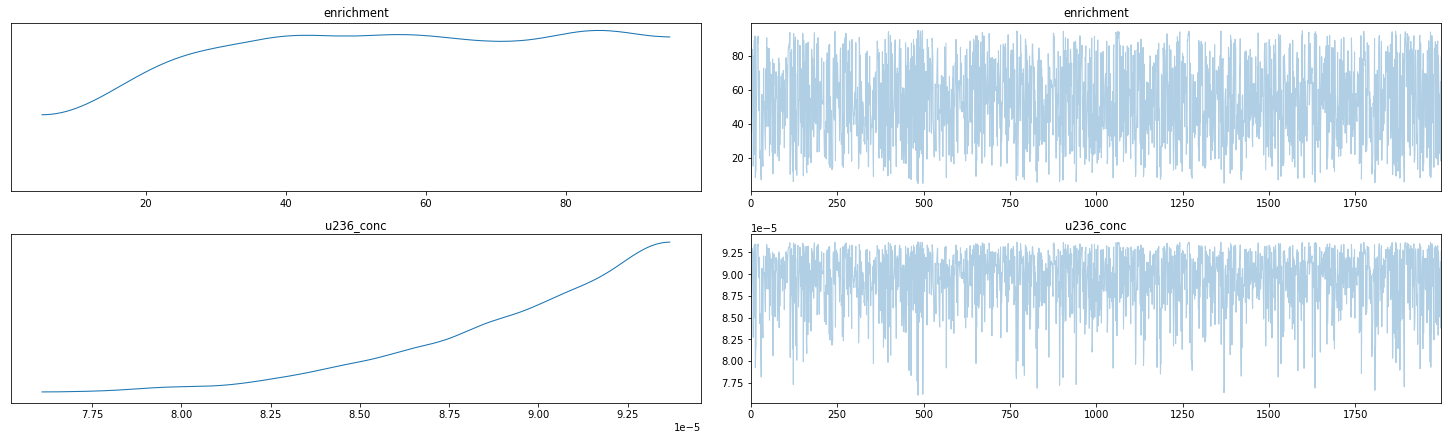

In [11]:
trace1 = run_pathological_model_1(sigma=1e-4)

Sequential sampling (1 chains in 1 job)
Slice: [enrichment]


Sampling 1 chain for 200 tune and 2_000 draw iterations (200 + 2_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


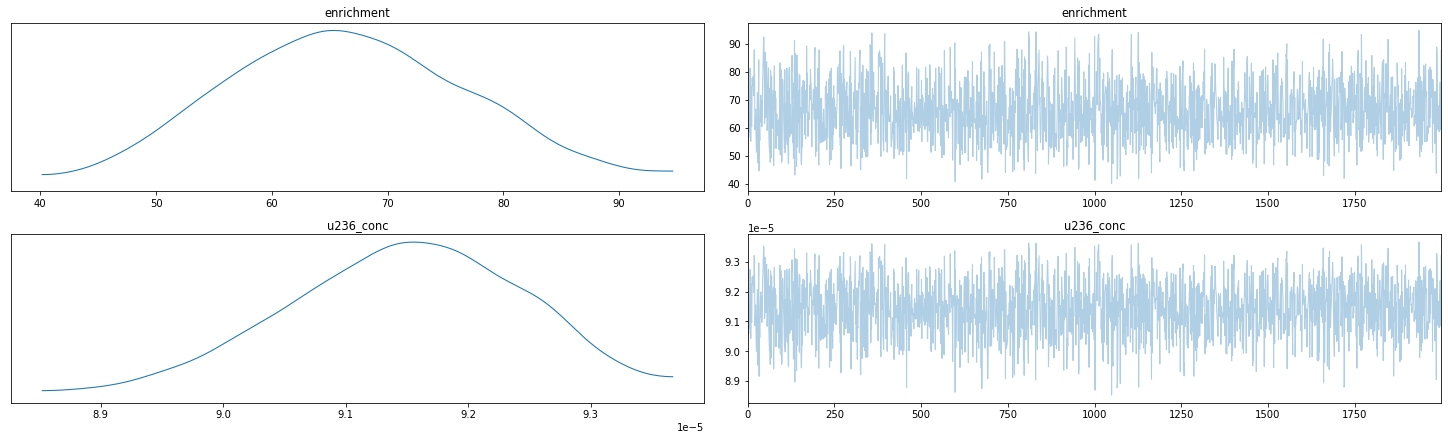

In [12]:
trace2 = run_pathological_model_1(sigma=1e-5)

Sequential sampling (1 chains in 1 job)
Slice: [enrichment]


Sampling 1 chain for 200 tune and 2_000 draw iterations (200 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


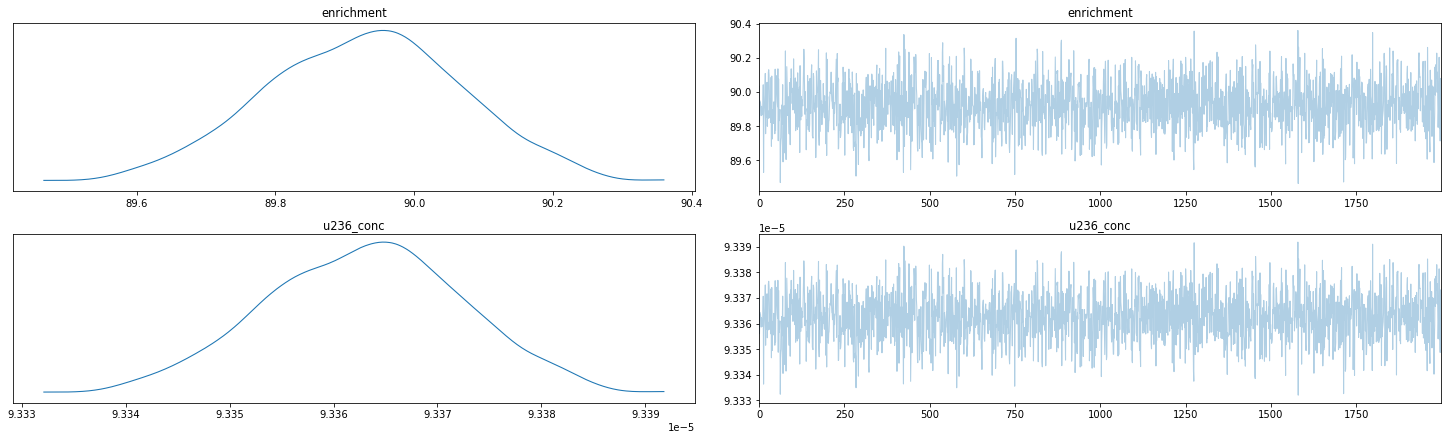

In [13]:
trace3 = run_pathological_model_1(sigma=1e-7)

Sequential sampling (1 chains in 1 job)
Slice: [enrichment]


Sampling 1 chain for 200 tune and 2_000 draw iterations (200 + 2_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


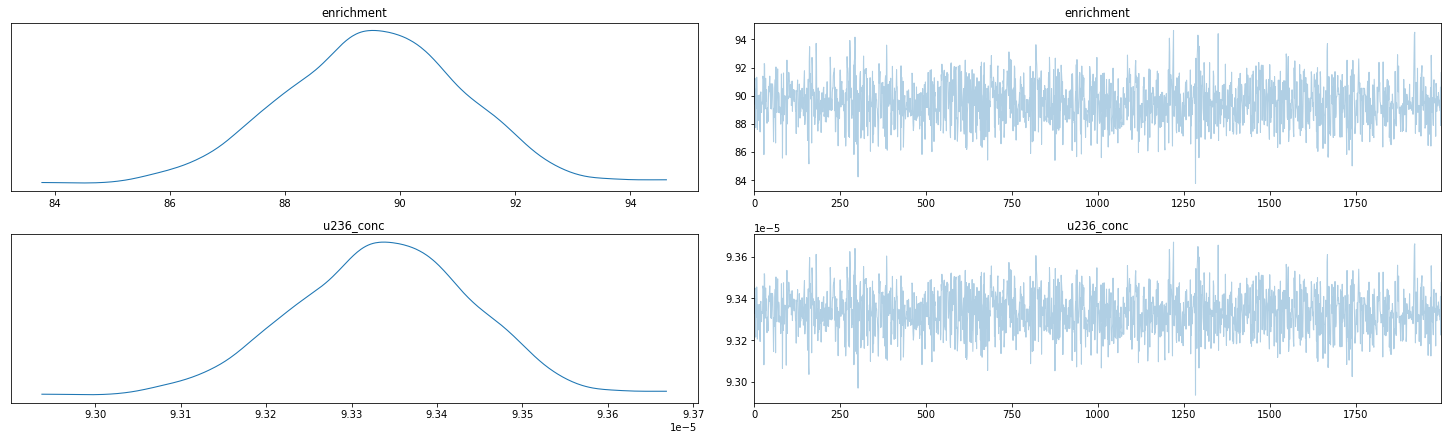

In [14]:
trace3 = run_pathological_model_1(sigma=1e-6)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f570412c190>,
      dtype=object)

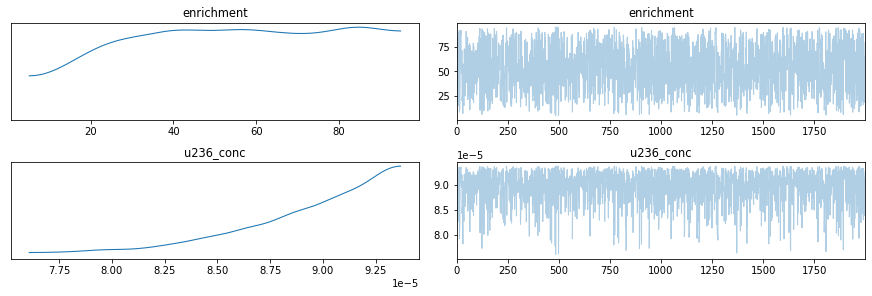

In [15]:
az.plot_trace(trace1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56db0362d0>],
      dtype=object)

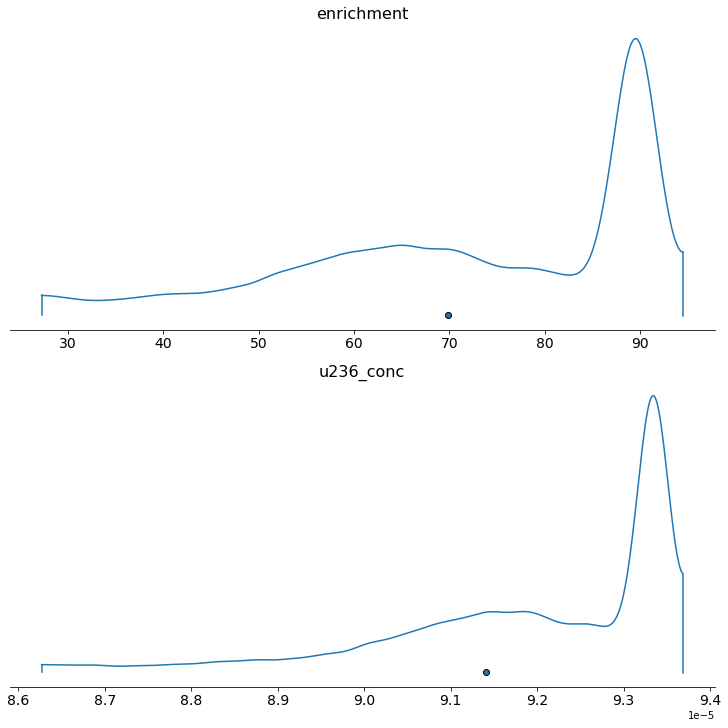

In [16]:
totaltrace = az.concat(trace1, trace2, trace3, dim='chain')
az.plot_density(totaltrace, grid=(len(totaltrace.posterior), 1), figsize=(10, len(totaltrace.posterior)*5))

In [24]:
totaltrace.posterior

<xarray.Dataset>
Dimensions:     (chain: 3, draw: 2000)
Coordinates:
  * chain       (chain) int64 0 1 2
  * draw        (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
Data variables:
    enrichment  (chain, draw) float64 42.44 57.74 35.48 ... 90.6 87.88 91.64
    u236_conc   (chain, draw) float64 8.886e-05 9.07e-05 ... 9.322e-05 9.348e-05
Attributes:
    created_at:                 2021-07-15 20:42:07.745571
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              1.9032814502716064
    tuning_steps:               200
    previous_created_at:        ['2021-07-15 20:42:07.745571', '2021-07-15T20...
    combined_sampling_time:     [1.9032814502716064, 0.7855539321899414, 0.98...

In [27]:
np.quantile(totaltrace.posterior.enrichment, .03)

19.124090965683138

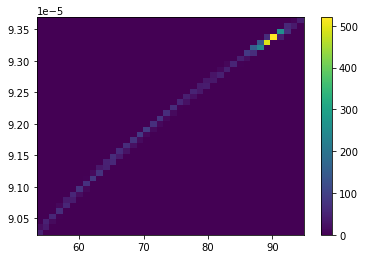

In [35]:
plt.hist2d(np.array(totaltrace.posterior.enrichment).reshape(6000), np.array(totaltrace.posterior.u236_conc).reshape(6000),
           bins=40, range=(
               (np.quantile(totaltrace.posterior.enrichment, .2), np.quantile(totaltrace.posterior.enrichment, 1)),
               (np.quantile(totaltrace.posterior.u236_conc, .2), np.quantile(totaltrace.posterior.u236_conc, 1))))
plt.colorbar()

In [19]:
a, b = totaltrace.posterior

In [20]:
len(totaltrace.posterior)

2